<a href="https://colab.research.google.com/github/Bast-94/ASL-PW/blob/main/TP_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Auto-encodeurs variationnels

Dans ce TP, dans un premier temps, nous allons entraîner un modèle génératif de type d'auto-encodeur variationnel sur le jeu de données MNIST (chiffres manuscrits de 0 à 9). Dans un deuxième, temps nous allons essayer de générer des chiffres en échantiollannant dans l'espace latent.

In [112]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd

# Définir l'architecture du VAE
class VAE(nn.Module):
    def __init__(self, latent_dim: int = 50,hidden_dim:int =400):
        super(VAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, hidden_dim)
        self.latent_dim = latent_dim
        self.fc21 = nn.Linear(hidden_dim, self.latent_dim)  # Moyenne mu
        self.fc22 = nn.Linear(hidden_dim, self.latent_dim)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(self.latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Chargement des données MNIST
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# Entraînement du modèle
def train_vae(vae: VAE, optimizer, train_loader, n_epochs=10, loss_function=loss_function, csv_filename=None):
    loss_list = []

    for epoch in tqdm(range(n_epochs)):
        vae.train()
        train_loss = 0

        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        epoch_loss = train_loss / len(train_loader.dataset)
        loss_list.append(epoch_loss)
        print(f'Epoch {epoch}, Loss: {epoch_loss}')

    # Enregistrez les pertes dans un fichier CSV si un nom de fichier est fourni
    if csv_filename:
        df = pd.DataFrame({'epoch': range(1, n_epochs + 1), 'loss': loss_list})
        df.to_csv(csv_filename, index=False)




In [93]:
vae(next(iter(train_loader))[0])[0].size()

torch.Size([128, 784])

In [94]:
next(iter(train_loader))[0].size()

torch.Size([128, 1, 28, 28])

## Exercices

* Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.
* Changer la dimension de l'espace latent.
* Changer l'architecture du VAE.
* Paramétrer la fonction loss pour pondérer les deux termes (reconstruction et régularisation).
* Optionnel : entraîner le modèle sur un autre dataset.

### Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
file_name='simple_vae.csv'
train_vae(vae,optimizer,train_loader=train_loader, csv_filename=file_name)

 10%|█         | 1/10 [00:17<02:40, 17.80s/it]

Epoch 0, Loss: 168.17282490234376


 20%|██        | 2/10 [00:39<02:39, 19.99s/it]

Epoch 1, Loss: 126.45485589192708


 30%|███       | 3/10 [01:04<02:35, 22.24s/it]

Epoch 2, Loss: 117.0715250813802


 40%|████      | 4/10 [01:26<02:13, 22.19s/it]

Epoch 3, Loss: 112.87972006835938


 50%|█████     | 5/10 [01:44<01:43, 20.65s/it]

Epoch 4, Loss: 110.63463544921875


 60%|██████    | 6/10 [02:01<01:18, 19.61s/it]

Epoch 5, Loss: 109.17744798177084


 70%|███████   | 7/10 [02:20<00:57, 19.32s/it]

Epoch 6, Loss: 108.15211590169271


 80%|████████  | 8/10 [02:38<00:37, 18.96s/it]

Epoch 7, Loss: 107.37716754557292


 90%|█████████ | 9/10 [02:56<00:18, 18.55s/it]

Epoch 8, Loss: 106.7668268391927


100%|██████████| 10/10 [03:15<00:00, 19.51s/it]

Epoch 9, Loss: 106.35055779622395


In [96]:
def sample_from_latent_space(vae: VAE, z=None):
  if(z is None):
    z = torch.randn(vae.latent_dim)
  return vae.decode(z).view(28,28)

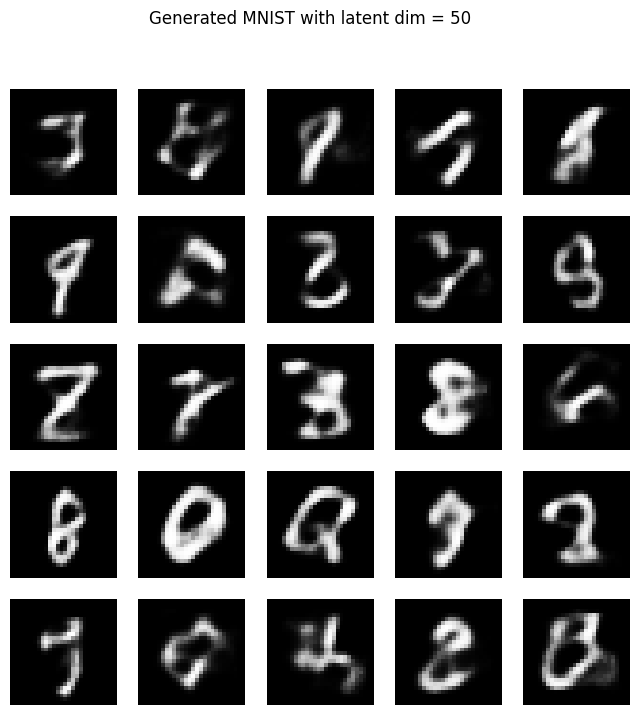

In [97]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

def generate_mnist(vae:VAE, file_name:str='generated_img.png'):
  transform = T.ToPILImage()
  col,row = 5,5
  full_size = col*row
  fig = plt.figure(figsize=(8,8))
  fig.suptitle(f"Generated MNIST with latent dim = {vae.latent_dim}")
  for i in range(full_size):
    ax = fig.add_subplot(row,col,i+1)
    tensor_img = sample_from_latent_space(vae)
    img = transform(tensor_img)
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')
  fig.savefig(file_name)
  plt.show()

generate_mnist(vae)


Nous pouvons remarquer que le modèle peut générer des images de chiffres qui sont reconnaissables comme les 7 et les 9. Cependant ceci ne représente qu'une minorité sur les images générées. Certaines ont des formes incohérentes d'autres sont partiellement dessinées.

### Changer la dimension de l'espace latent.

Dans notre premier cas la dimension latente était de 50, nous allons la diminuer à  10 d'une part et augmenter à 100 d'autre part et observer la qualité des résultats générés mais aussi les loss respectives.

In [114]:
import pandas as pd
vae_10 = VAE(latent_dim=10)
vae_100 = VAE(latent_dim=100)

# Initialiser les listes pour stocker les losses
losses_10 = []
losses_100 = []

for network, file_name in zip([vae_10, vae_100], ['vae10.csv', 'vae_100.csv']):
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
    train_vae(network, optimizer=optimizer, train_loader=train_loader, n_epochs=10, csv_filename=file_name)



  7%|▋         | 1/15 [00:17<03:59, 17.13s/it]

Epoch 0, Loss: 163.38217443033855


 13%|█▎        | 2/15 [00:34<03:44, 17.23s/it]

Epoch 1, Loss: 124.9856326171875


 20%|██        | 3/15 [00:53<03:35, 17.98s/it]

Epoch 2, Loss: 119.62180458984375


 27%|██▋       | 4/15 [01:19<03:53, 21.18s/it]

Epoch 3, Loss: 116.93407203776042


 33%|███▎      | 5/15 [01:39<03:28, 20.88s/it]

Epoch 4, Loss: 115.22259835611979


 40%|████      | 6/15 [01:59<03:04, 20.49s/it]

Epoch 5, Loss: 113.9792737467448


 47%|████▋     | 7/15 [02:18<02:38, 19.86s/it]

Epoch 6, Loss: 113.06645006510416


 53%|█████▎    | 8/15 [02:36<02:15, 19.40s/it]

Epoch 7, Loss: 112.3009098795573


 60%|██████    | 9/15 [03:02<02:09, 21.51s/it]

Epoch 8, Loss: 111.66112418619791


 67%|██████▋   | 10/15 [03:23<01:46, 21.22s/it]

Epoch 9, Loss: 111.10257888997396


 73%|███████▎  | 11/15 [03:41<01:21, 20.27s/it]

Epoch 10, Loss: 110.59616095377604


 80%|████████  | 12/15 [03:58<00:58, 19.35s/it]

Epoch 11, Loss: 110.15457412109375


 87%|████████▋ | 13/15 [04:15<00:37, 18.73s/it]

Epoch 12, Loss: 109.73315935872395


 93%|█████████▎| 14/15 [04:34<00:18, 18.85s/it]

Epoch 13, Loss: 109.37369729817708


100%|██████████| 15/15 [04:53<00:00, 19.55s/it]


Epoch 14, Loss: 109.01950594075521


  7%|▋         | 1/15 [00:18<04:12, 18.06s/it]

Epoch 0, Loss: 172.04090354817708


 13%|█▎        | 2/15 [00:36<03:57, 18.29s/it]

Epoch 1, Loss: 131.41640838216145


 20%|██        | 3/15 [00:55<03:40, 18.38s/it]

Epoch 2, Loss: 119.78032841796875


 27%|██▋       | 4/15 [01:14<03:28, 18.93s/it]

Epoch 3, Loss: 114.01783406575521


 33%|███▎      | 5/15 [01:34<03:12, 19.27s/it]

Epoch 4, Loss: 111.0555372233073


 40%|████      | 6/15 [01:54<02:55, 19.46s/it]

Epoch 5, Loss: 109.32092366536459


 47%|████▋     | 7/15 [02:13<02:33, 19.24s/it]

Epoch 6, Loss: 108.22849376627605


 53%|█████▎    | 8/15 [02:32<02:15, 19.32s/it]

Epoch 7, Loss: 107.40545524088542


 60%|██████    | 9/15 [02:51<01:55, 19.27s/it]

Epoch 8, Loss: 106.7758190266927


 67%|██████▋   | 10/15 [03:11<01:36, 19.31s/it]

Epoch 9, Loss: 106.3417775390625


 73%|███████▎  | 11/15 [03:30<01:17, 19.40s/it]

Epoch 10, Loss: 105.90821832682292


 80%|████████  | 12/15 [03:49<00:57, 19.23s/it]

Epoch 11, Loss: 105.55667076822917


 87%|████████▋ | 13/15 [04:09<00:38, 19.45s/it]

Epoch 12, Loss: 105.2514465657552


 93%|█████████▎| 14/15 [04:28<00:19, 19.22s/it]

Epoch 13, Loss: 105.0986612467448


100%|██████████| 15/15 [04:48<00:00, 19.21s/it]

Epoch 14, Loss: 104.86683826497396


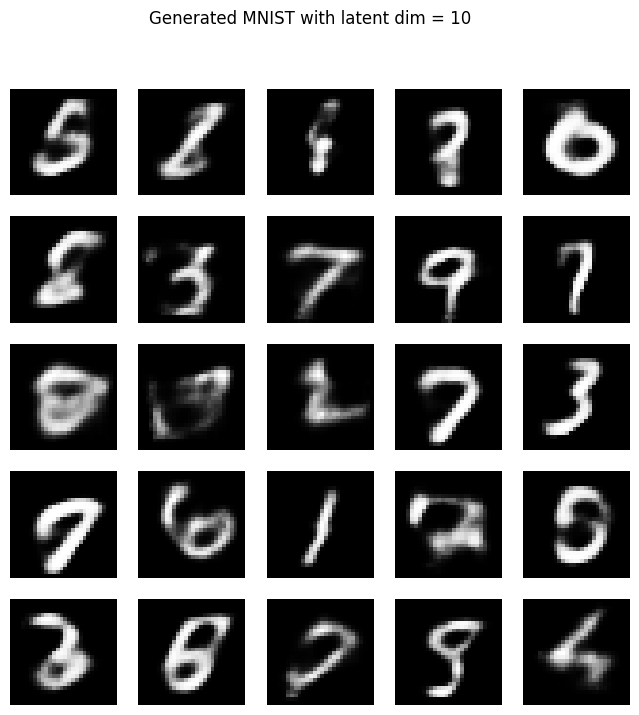

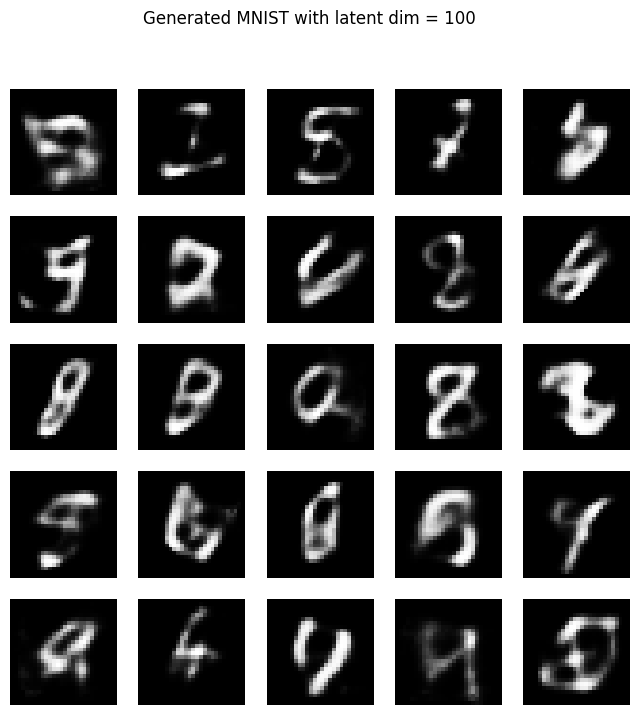

In [115]:
for network,name in zip([vae_10,vae_100],['VAE_10','VAE_100']):
  generate_mnist(network,f'{name}.png')

On remarque encore une fois que les données générées sont en majorité invraisemblables pour un humain. Notons toutefois que les chiffres 9, 7 et 1 sont reconnaissables par comparaison avec les autres.

### Changer L'architecture du VAE

L'auto-encodeur variationnel a besoin d'être adapté pour les images, il doit donc avoir des couches de convolution pour l'encodeur et le décodeur.

In [116]:
alt_train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)
next(iter(alt_train_loader))[0].shape

torch.Size([128, 1, 28, 28])

In [117]:
class AltVAE(nn.Module):
    def __init__(self, latent_dim:int,n_channel:int,width:int, height:int,hidden_dim:int=512):
        super(AltVAE, self).__init__()

        # Encodeur

        self.enc = nn.Sequential(
            nn.Conv2d(n_channel, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )


        enc_output = self.enc(torch.zeros(1,n_channel,width,height))
        enc_output = enc_output.view(enc_output.shape[0],-1)
        fc_input_size = enc_output.shape[1]
        self.latent_dim = latent_dim
        self.fc21 = nn.Linear(fc_input_size, self.latent_dim)  # Moyenne mu
        self.fc22 = nn.Linear(fc_input_size, self.latent_dim)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(self.latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 784)

    def encode(self, x):
        h1 = torch.relu(self.enc(x))
        h1 = h1.view(h1.size(0), -1)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

latent_dim = 50

sample = next(iter(alt_train_loader))[0]
my_vae = AltVAE(latent_dim,1,28,28)
xhat, mean, log_var = my_vae(sample)
output_shape = sample.view(len(sample),-1).shape
assert xhat.shape == output_shape
assert len(mean.shape) == 2 and mean.shape[1] == latent_dim
assert len(log_var.shape) == 2 and log_var.shape[1] == latent_dim
print("Les shapes du VAE sont cohérentes")

Les shapes du VAE sont cohérentes


### Paramétrer la fonction loss pour pondérer les deux termes

Nous allons créer une fonction de loss qui puisse apprendre à paramétrer la pondération des deux termes

In [118]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.beta = nn.Parameter(torch.tensor(1.0))

    def forward(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return self.alpha * BCE + self.beta * KLD


In [119]:


"""n_epochs =10

for epoch in (range(n_epochs)):
      my_vae.train()
      train_loss = 0
      for data, _ in tqdm(train_loader):
          data = data.to(device)

          optimizer.zero_grad()
          recon_batch, mu, logvar = my_vae(data)
          loss = loss_func(recon_batch, data, mu, logvar)
          loss.backward()
          train_loss += loss.item()
          optimizer.step()

      print(f'Epoch {epoch}, Loss: {train_loss / len(alt_train_loader.dataset)}')"""
my_vae = AltVAE(latent_dim,1,28,28,512).to(device)
optimizer = torch.optim.Adam(my_vae.parameters(), lr=1e-3)
loss_func = CustomLoss()
train_vae(my_vae,optimizer,alt_train_loader,loss_function=loss_func,csv_filename='my_vae.csv')


100%|██████████| 469/469 [01:32<00:00,  5.09it/s]


Epoch 0, Loss: 169.07035177408855


100%|██████████| 469/469 [01:31<00:00,  5.13it/s]


Epoch 1, Loss: 123.54468126627604


100%|██████████| 469/469 [01:31<00:00,  5.10it/s]


Epoch 2, Loss: 115.09705126953125


100%|██████████| 469/469 [01:31<00:00,  5.15it/s]


Epoch 3, Loss: 111.53718911132812


100%|██████████| 469/469 [01:31<00:00,  5.11it/s]


Epoch 4, Loss: 109.52513307291666


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


Epoch 5, Loss: 108.14193289388021


100%|██████████| 469/469 [01:31<00:00,  5.10it/s]


Epoch 6, Loss: 107.2617723470052


100%|██████████| 469/469 [01:34<00:00,  4.97it/s]


Epoch 7, Loss: 106.55753263346354


100%|██████████| 469/469 [01:32<00:00,  5.05it/s]


Epoch 8, Loss: 106.06616837565105


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]

Epoch 9, Loss: 105.66866795247395


Nous obtenons en définitive une loss qui est légèrment inférieure à celle de l'auto-encodeur de départ.

In [120]:
print("Alpha =",loss_func.alpha.item())
print("Beta =",loss_func.beta.item())

Alpha = 1.0
Beta = 1.0


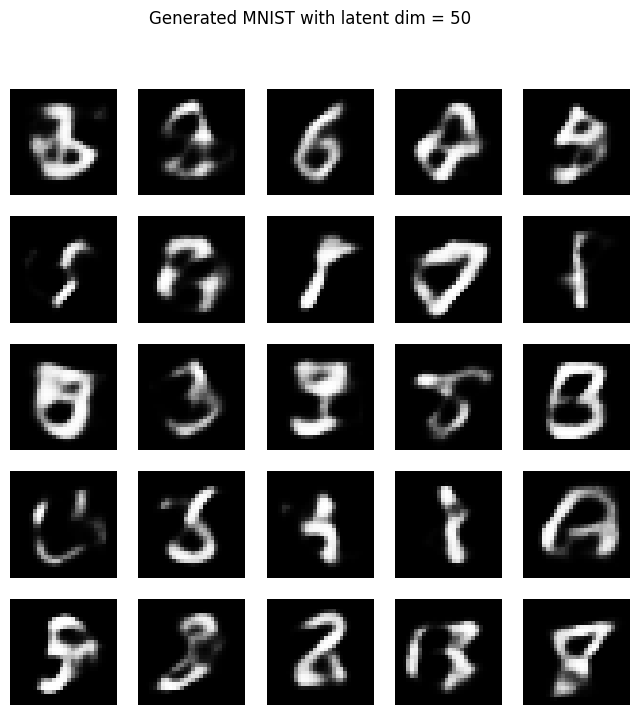

In [121]:
generate_mnist(my_vae,file_name='self_vae.png')